In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Terrain Recognition**

In [24]:
import timm
import torch
import torchvision
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from PIL import Image
torch.manual_seed(42)

In [25]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
torch.cuda.is_available()

True

* # Classes
* The problem statement SIH1418 had given us with a task to classify terrains under four categories namely `Grassy`, `Marshy`, `Rocky`, `Sandy`.

In [27]:
classes = np.sort(os.listdir('/kaggle/input/terrain-recognition/Data Main/train'))

In [28]:
classes

array(['Grassy', 'Marshy', 'Rocky', 'Sandy'], dtype='<U6')

# Custom Dataset
* We encoded 4 categorical classes to numbers and also preprocessed our data to better fit our model.

In [29]:
class dataset(Dataset):
    def __init__(self,folder,transform=None):
        self.transform=transform
        self.folder=folder
        self.lis=np.sort(os.listdir(folder))
    def __len__(self):    
        a=0
        size={}
        for i in self.lis:
            size[i]=len(os.listdir(self.folder+'/'+i))
            a+=size[i]
        return a
    def __getitem__(self,idx):
        if idx<len(os.listdir(self.folder+'/'+self.lis[0])):
            y=torch.tensor(0)
            x=self.folder+'/'+self.lis[0]+'/'+np.sort(os.listdir(self.folder+'/'+self.lis[0]))[idx]
        elif idx>=len(os.listdir(self.folder+'/'+self.lis[0])) and idx<len(os.listdir(self.folder+'/'+self.lis[1]))+len(os.listdir(self.folder+'/'+self.lis[0])):
            y=torch.tensor(1)
            x=self.folder+'/'+self.lis[1]+'/'+np.sort(os.listdir(self.folder+'/'+self.lis[1]))[idx-len(os.listdir(self.folder+'/'+self.lis[0]))]
        elif idx>=len(os.listdir(self.folder+'/'+self.lis[1]))+len(os.listdir(self.folder+'/'+self.lis[0])) and idx<len(os.listdir(self.folder+'/'+self.lis[2]))+len(os.listdir(self.folder+'/'+self.lis[1]))+len(os.listdir(self.folder+'/'+self.lis[0])):
            y=torch.tensor(2)
            x=self.folder+'/'+self.lis[2]+'/'+np.sort(os.listdir(self.folder+'/'+self.lis[2]))[idx-len(os.listdir(self.folder+'/'+self.lis[0]))-len(os.listdir(self.folder+'/'+self.lis[1]))]
        else:
            y=torch.tensor(3)
            x=self.folder+'/'+self.lis[3]+'/'+np.sort(os.listdir(self.folder+'/'+self.lis[3]))[idx-len(os.listdir(self.folder+'/'+self.lis[0]))-len(os.listdir(self.folder+'/'+self.lis[1]))-len(os.listdir(self.folder+'/'+self.lis[2]))]
        return [self.transform(np.array(Image.open(x))), y]
    
#     {'x':self.transform(np.array(Image.open(x))),'y':y}
    def size(self):
        a=0
        size={}
        for i in self.lis:
            size[i]=len(os.listdir(self.folder+'/'+i))
            a+=size[i]
        return size

In [30]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023,0.1994,0.2010))])

In [31]:
data = dataset('/kaggle/input/terrain-recognition/Data Main/train', transform=transform)

In [32]:
data.size()

{'Grassy': 8512, 'Marshy': 7727, 'Rocky': 7668, 'Sandy': 7664}

In [33]:
data_loader=DataLoader(dataset=data,batch_size=32,shuffle=True)

In [36]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [37]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = Identity()

In [38]:
model.fc = nn.Linear(512, 4)

In [39]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
losses = []
n_total_steps = len(data_loader)
num_epochs = 1
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1)%32==0:
            print(f"epoch: {epoch+1}/{num_epochs}| step: {i+1}/{n_total_steps}, loss: {loss.item():.3f}")

epoch: 1/1| step: 32/987, loss: 0.739
epoch: 1/1| step: 64/987, loss: 0.584
epoch: 1/1| step: 96/987, loss: 0.256
epoch: 1/1| step: 128/987, loss: 0.338
epoch: 1/1| step: 160/987, loss: 0.471
epoch: 1/1| step: 192/987, loss: 0.308
epoch: 1/1| step: 224/987, loss: 0.305
epoch: 1/1| step: 256/987, loss: 0.324
epoch: 1/1| step: 288/987, loss: 0.403
epoch: 1/1| step: 320/987, loss: 0.343
epoch: 1/1| step: 352/987, loss: 0.132
epoch: 1/1| step: 384/987, loss: 0.337
epoch: 1/1| step: 416/987, loss: 0.219
epoch: 1/1| step: 448/987, loss: 0.131
epoch: 1/1| step: 480/987, loss: 0.258
epoch: 1/1| step: 512/987, loss: 0.276
epoch: 1/1| step: 544/987, loss: 0.364
epoch: 1/1| step: 576/987, loss: 0.215
epoch: 1/1| step: 608/987, loss: 0.177
epoch: 1/1| step: 640/987, loss: 0.313
epoch: 1/1| step: 672/987, loss: 0.384
epoch: 1/1| step: 704/987, loss: 0.189
epoch: 1/1| step: 736/987, loss: 0.173
epoch: 1/1| step: 768/987, loss: 0.229
epoch: 1/1| step: 800/987, loss: 0.581
epoch: 1/1| step: 832/987, l

In [41]:
val_set = dataset('/kaggle/input/terrain-recognition/Data Main/val', transform=transform) 

In [42]:
print("Finished Training")
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [43]:
val_loader = DataLoader(dataset=val_set,batch_size=32,shuffle=True)
n_batches = len(val_loader)
batch_size = 32
predictions = torch.zeros((batch_size, 1))
all_labels = torch.zeros((batch_size, 1))
with torch.no_grad():
    n_correct = 0
    n_class_correct = np.zeros(4)
    n_class_samples = np.zeros(4)
    count = 0
    for images, labels in val_loader:
        count += 1
        images = images.to(device)
        labels = labels.to(device)
        predictions = predictions.to(device)
        all_labels = all_labels.to(device)
        all_labels = torch.cat((all_labels.view(all_labels.size(0),1), labels.view(labels.size(0), 1)), 0)
        outputs = model(images)
        predicted = torch.argmax(outputs, 1)
        predictions = torch.cat((predictions.view(predictions.size(0),1), predicted.view(labels.size(0), 1)), 0)
        n_correct += (predicted==labels).sum().item()
        for i in range(labels.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    accuracy = n_correct/(32*n_batches)
    print(f"Accuracy of the network: {accuracy}")
    for i in range(4):
        acc = 100.0*n_class_correct[i] / n_class_samples[i]
        print(f"Accuracy {classes[i]}: {acc} %")
    

Accuracy of the network: 0.9198113207547169
Accuracy Grassy: 97.86184210526316 %
Accuracy Marshy: 81.21980676328502 %
Accuracy Rocky: 92.93974437005478 %
Accuracy Sandy: 96.4068209500609 %


In [44]:
all_labels = all_labels.to(device='cpu')
predictions = predictions.to(device='cpu')

In [45]:
f1_score = torchmetrics.classification.MulticlassF1Score(4, average=None)
score = f1_score(predictions, all_labels)
print(score)

tensor([0.9330, 0.8700, 0.9122, 0.9715])


In [53]:
import matplotlib.pyplot as plt

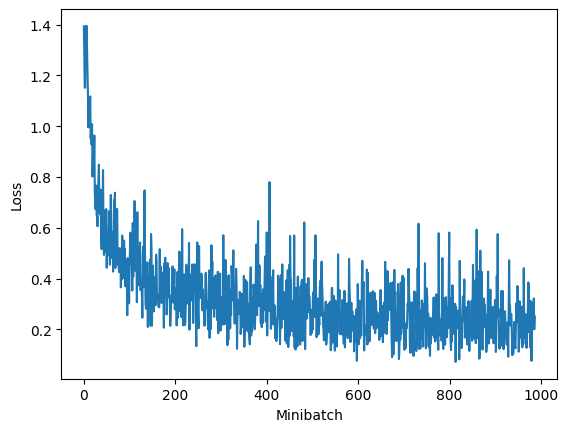

In [54]:
plt.plot(np.arange(987),losses)
plt.xlabel('Minibatch')
plt.ylabel('Loss')
plt.show()

In [55]:
model=model.to(device='cpu')

In [56]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
import pickle 
pickle_out = open("classifier.pkl","wb")
pickle.dump(model,pickle_out)
pickle_out.close

<function BufferedWriter.close>

In [58]:
test_set = dataset('/kaggle/input/terrain-recognition/Data Main/test', transform=transform)

In [60]:
model=model.to(device='cuda')

In [61]:
test_loader = DataLoader(dataset=test_set,batch_size=32,shuffle=True)
t_batches = len(test_loader)
with torch.no_grad():
    n_correct = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, 1)
        n_correct += (predicted==labels).sum().item()
    print("test set accuracy is",n_correct/(32*n_batches))
    

test set accuracy is 0.9380896226415094
